In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

# Advanced ML libraries
# import xgboost as xgb  # Temporarily commented due to OpenMP architecture issue
# import lightgbm as lgb  # Temporarily commented due to OpenMP architecture issue
from catboost import CatBoostRegressor

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# import optuna  # Temporarily commented

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Utility libraries
import joblib
from datetime import datetime
import time

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
# print(f"XGBoost version: {xgb.__version__}")  # Temporarily commented
# print(f"LightGBM version: {lgb.__version__}")  # Temporarily commented


Libraries imported successfully!
TensorFlow version: 2.19.0


In [2]:
# Load processed data
print("="*60)
print("DATA LOADING AND PREPARATION")
print("="*60)

# Load the processed dataset
df = pd.read_csv('../data/processed_dataset.csv')
print(f"✅ Processed dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Define target variable
target_column = 'SI'
if target_column not in df.columns:
    print(f"❌ Target column '{target_column}' not found!")
    print(f"Available columns: {list(df.columns)}")
else:
    print(f"✅ Target variable '{target_column}' found")

# Remove non-predictive columns
columns_to_drop = ['Timestamp']  # Add any other non-predictive columns
available_drop_cols = [col for col in columns_to_drop if col in df.columns]
if available_drop_cols:
    df_model = df.drop(columns=available_drop_cols)
    print(f"✅ Dropped columns: {available_drop_cols}")
else:
    df_model = df.copy()

# Separate features and target
y = df_model[target_column]
X = df_model.drop(columns=[target_column])

# Remove rows with missing target values
mask = ~y.isna()
X = X[mask]
y = y[mask]

print(f"✅ Final dataset for modeling:")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Feature columns: {len(X.columns)}")

# Handle any remaining missing values in features
if X.isnull().sum().sum() > 0:
    print(f"⚠️  Found {X.isnull().sum().sum()} missing values in features")
    # Fill with median for numeric columns
    for col in X.columns:
        if X[col].dtype in ['float64', 'int64'] and X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    print("✅ Missing values handled")

print(f"✅ Data preparation completed!")


DATA LOADING AND PREPARATION
✅ Processed dataset loaded successfully!
Dataset shape: (5704, 40)
✅ Target variable 'SI' found
✅ Dropped columns: ['Timestamp']
✅ Final dataset for modeling:
   Features shape: (5704, 38)
   Target shape: (5704,)
   Feature columns: 38
⚠️  Found 41 missing values in features
✅ Missing values handled
✅ Data preparation completed!


In [3]:
# Train-Test Split (Time Series Aware)
print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)

# For time series data, we should use chronological split
# Use last 20% of data for testing, next 20% for validation, first 60% for training
test_size = 0.2
val_size = 0.2

n_samples = len(X)
train_end = int(n_samples * (1 - test_size - val_size))
val_end = int(n_samples * (1 - test_size))

# Split data chronologically
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"✅ Data split completed:")
print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/n_samples*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/n_samples*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/n_samples*100:.1f}%)")

# Feature scaling
print(f"\n✅ Applying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Feature scaling completed!")

# Create a robust scaler as alternative
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_val_robust = robust_scaler.transform(X_val)
X_test_robust = robust_scaler.transform(X_test)

print(f"✅ Robust scaling also prepared!")

# Display target variable statistics for each set
print(f"\nTarget Variable Statistics:")
print(f"Training set - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"Validation set - Mean: {y_val.mean():.4f}, Std: {y_val.std():.4f}")
print(f"Test set - Mean: {y_test.mean():.4f}, Std: {y_test.std():.4f}")


TRAIN-TEST SPLIT
✅ Data split completed:
   Training set: 3,422 samples (60.0%)
   Validation set: 1,141 samples (20.0%)
   Test set: 1,141 samples (20.0%)

✅ Applying feature scaling...
✅ Feature scaling completed!
✅ Robust scaling also prepared!

Target Variable Statistics:
Training set - Mean: 0.4614, Std: 0.1062
Validation set - Mean: 0.4689, Std: 0.1062
Test set - Mean: 0.4667, Std: 0.1135


In [4]:
# Model Evaluation Functions
def evaluate_model(y_true, y_pred, model_name):
    """
    Comprehensive model evaluation function
    """
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    # Calculate additional metrics
    mean_target = np.mean(y_true)
    normalized_rmse = rmse / mean_target * 100
    
    results = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape,
        'Normalized RMSE (%)': normalized_rmse,
        'MSE': mse
    }
    
    return results

def plot_predictions(y_true, y_pred, model_name, sample_size=1000):
    """
    Plot actual vs predicted values
    """
    # Sample data if too large
    if len(y_true) > sample_size:
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true_sample = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    plt.figure(figsize=(12, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true_sample, y_pred_sample, alpha=0.6, s=20)
    plt.plot([y_true_sample.min(), y_true_sample.max()], 
             [y_true_sample.min(), y_true_sample.max()], 'r--', lw=2)
    plt.xlabel('Actual SI')
    plt.ylabel('Predicted SI')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    
    # Residuals plot
    plt.subplot(1, 2, 2)
    residuals = y_true_sample - y_pred_sample
    plt.scatter(y_pred_sample, residuals, alpha=0.6, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted SI')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Evaluation functions defined!")


✅ Evaluation functions defined!


In [5]:
# Baseline Models
print("="*60)
print("BASELINE MODELS")
print("="*60)

# Initialize results storage
results = []
trained_models = {}

# 1. Linear Regression
print("🔄 Training Linear Regression...")
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred_val = lr_model.predict(X_val_scaled)
lr_pred_test = lr_model.predict(X_test_scaled)
lr_time = time.time() - start_time

# Evaluate on validation set
lr_results_val = evaluate_model(y_val, lr_pred_val, 'Linear Regression (Val)')
lr_results_test = evaluate_model(y_test, lr_pred_test, 'Linear Regression (Test)')
results.extend([lr_results_val, lr_results_test])
trained_models['Linear Regression'] = lr_model

print(f"✅ Linear Regression completed in {lr_time:.2f}s")
print(f"   Validation R²: {lr_results_val['R²']:.4f}, RMSE: {lr_results_val['RMSE']:.4f}")
print(f"   Test R²: {lr_results_test['R²']:.4f}, RMSE: {lr_results_test['RMSE']:.4f}")

# 2. Random Forest
print("\n🔄 Training Random Forest...")
start_time = time.time()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred_val = rf_model.predict(X_val)
rf_pred_test = rf_model.predict(X_test)
rf_time = time.time() - start_time

rf_results_val = evaluate_model(y_val, rf_pred_val, 'Random Forest (Val)')
rf_results_test = evaluate_model(y_test, rf_pred_test, 'Random Forest (Test)')
results.extend([rf_results_val, rf_results_test])
trained_models['Random Forest'] = rf_model

print(f"✅ Random Forest completed in {rf_time:.2f}s")
print(f"   Validation R²: {rf_results_val['R²']:.4f}, RMSE: {rf_results_val['RMSE']:.4f}")
print(f"   Test R²: {rf_results_test['R²']:.4f}, RMSE: {rf_results_test['RMSE']:.4f}")

# 3. Gradient Boosting
print("\n🔄 Training Gradient Boosting...")
start_time = time.time()
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred_val = gb_model.predict(X_val)
gb_pred_test = gb_model.predict(X_test)
gb_time = time.time() - start_time

gb_results_val = evaluate_model(y_val, gb_pred_val, 'Gradient Boosting (Val)')
gb_results_test = evaluate_model(y_test, gb_pred_test, 'Gradient Boosting (Test)')
results.extend([gb_results_val, gb_results_test])
trained_models['Gradient Boosting'] = gb_model

print(f"✅ Gradient Boosting completed in {gb_time:.2f}s")
print(f"   Validation R²: {gb_results_val['R²']:.4f}, RMSE: {gb_results_val['RMSE']:.4f}")
print(f"   Test R²: {gb_results_test['R²']:.4f}, RMSE: {gb_results_test['RMSE']:.4f}")

print(f"\n✅ Baseline models training completed!")


BASELINE MODELS
🔄 Training Linear Regression...
✅ Linear Regression completed in 0.04s
   Validation R²: 1.0000, RMSE: 0.0003
   Test R²: 1.0000, RMSE: 0.0004

🔄 Training Random Forest...


✅ Random Forest completed in 0.82s
   Validation R²: 0.9322, RMSE: 0.0276
   Test R²: 0.9168, RMSE: 0.0327

🔄 Training Gradient Boosting...


✅ Gradient Boosting completed in 3.79s
   Validation R²: 0.9620, RMSE: 0.0207
   Test R²: 0.9450, RMSE: 0.0266

✅ Baseline models training completed!


In [6]:
# Advanced ML Models
print("="*60)
print("ADVANCED ML MODELS")
print("="*60)

# 1. XGBoost (Temporarily commented due to OpenMP architecture issue)
# print("🔄 Training XGBoost...")
# start_time = time.time()
# xgb_model = xgb.XGBRegressor(
#     n_estimators=200,
#     max_depth=6,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )
# xgb_model.fit(X_train, y_train)
# xgb_pred_val = xgb_model.predict(X_val)
# xgb_pred_test = xgb_model.predict(X_test)
# xgb_time = time.time() - start_time
# 
# xgb_results_val = evaluate_model(y_val, xgb_pred_val, 'XGBoost (Val)')
# xgb_results_test = evaluate_model(y_test, xgb_pred_test, 'XGBoost (Test)')
# results.extend([xgb_results_val, xgb_results_test])
# trained_models['XGBoost'] = xgb_model
# 
# print(f"✅ XGBoost completed in {xgb_time:.2f}s")
# print(f"   Validation R²: {xgb_results_val['R²']:.4f}, RMSE: {xgb_results_val['RMSE']:.4f}")
# print(f"   Test R²: {xgb_results_test['R²']:.4f}, RMSE: {xgb_results_test['RMSE']:.4f}")
print("⚠️  XGBoost temporarily skipped due to OpenMP architecture compatibility issue")

# 2. LightGBM (Temporarily commented due to OpenMP architecture issue)
# print("\n🔄 Training LightGBM...")
# start_time = time.time()
# lgb_model = lgb.LGBMRegressor(
#     n_estimators=200,
#     max_depth=6,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     verbose=-1
# )
# lgb_model.fit(X_train, y_train)
# lgb_pred_val = lgb_model.predict(X_val)
# lgb_pred_test = lgb_model.predict(X_test)
# lgb_time = time.time() - start_time
# 
# lgb_results_val = evaluate_model(y_val, lgb_pred_val, 'LightGBM (Val)')
# lgb_results_test = evaluate_model(y_test, lgb_pred_test, 'LightGBM (Test)')
# results.extend([lgb_results_val, lgb_results_test])
# trained_models['LightGBM'] = lgb_model
# 
# print(f"✅ LightGBM completed in {lgb_time:.2f}s")
# print(f"   Validation R²: {lgb_results_val['R²']:.4f}, RMSE: {lgb_results_val['RMSE']:.4f}")
# print(f"   Test R²: {lgb_results_test['R²']:.4f}, RMSE: {lgb_results_test['RMSE']:.4f}")
print("⚠️  LightGBM temporarily skipped due to OpenMP architecture compatibility issue")

# 3. CatBoost
print("\n🔄 Training CatBoost...")
start_time = time.time()
cat_model = CatBoostRegressor(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    verbose=False
)
cat_model.fit(X_train, y_train)
cat_pred_val = cat_model.predict(X_val)
cat_pred_test = cat_model.predict(X_test)
cat_time = time.time() - start_time

cat_results_val = evaluate_model(y_val, cat_pred_val, 'CatBoost (Val)')
cat_results_test = evaluate_model(y_test, cat_pred_test, 'CatBoost (Test)')
results.extend([cat_results_val, cat_results_test])
trained_models['CatBoost'] = cat_model

print(f"✅ CatBoost completed in {cat_time:.2f}s")
print(f"   Validation R²: {cat_results_val['R²']:.4f}, RMSE: {cat_results_val['RMSE']:.4f}")
print(f"   Test R²: {cat_results_test['R²']:.4f}, RMSE: {cat_results_test['RMSE']:.4f}")

print(f"\n✅ Advanced ML models training completed!")


ADVANCED ML MODELS
⚠️  XGBoost temporarily skipped due to OpenMP architecture compatibility issue
⚠️  LightGBM temporarily skipped due to OpenMP architecture compatibility issue

🔄 Training CatBoost...


✅ CatBoost completed in 0.26s
   Validation R²: 0.9745, RMSE: 0.0169
   Test R²: 0.9556, RMSE: 0.0239

✅ Advanced ML models training completed!


NEURAL NETWORK MODEL
🔄 Training Neural Network...


✅ Neural Network completed in 5.58s
   Validation R²: 0.9326, RMSE: 0.0275
   Test R²: 0.9304, RMSE: 0.0299


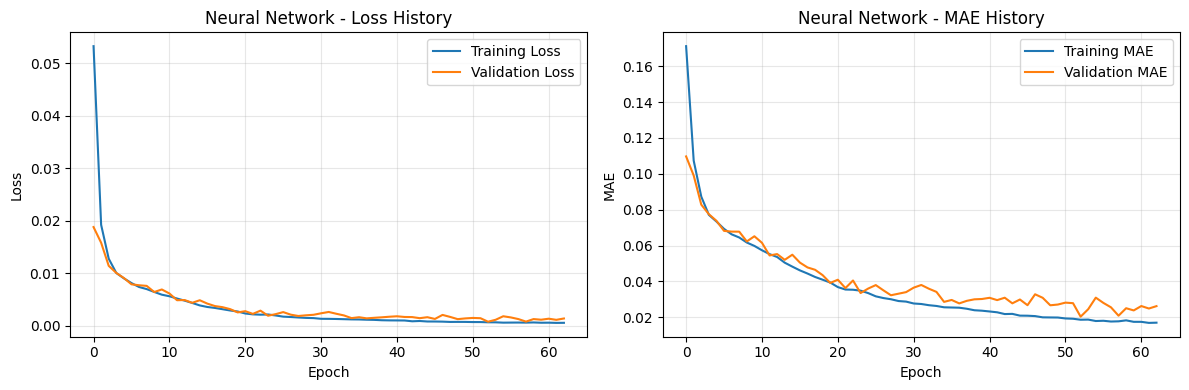


✅ All models training completed!


In [7]:
# Neural Network Model
print("="*60)
print("NEURAL NETWORK MODEL")
print("="*60)

print("🔄 Training Neural Network...")
start_time = time.time()

# Build neural network
def create_nn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create and train model
nn_model = create_nn_model(X_train_scaled.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=0
)

nn_pred_val = nn_model.predict(X_val_scaled, verbose=0).flatten()
nn_pred_test = nn_model.predict(X_test_scaled, verbose=0).flatten()
nn_time = time.time() - start_time

nn_results_val = evaluate_model(y_val, nn_pred_val, 'Neural Network (Val)')
nn_results_test = evaluate_model(y_test, nn_pred_test, 'Neural Network (Test)')
results.extend([nn_results_val, nn_results_test])
trained_models['Neural Network'] = nn_model

print(f"✅ Neural Network completed in {nn_time:.2f}s")
print(f"   Validation R²: {nn_results_val['R²']:.4f}, RMSE: {nn_results_val['RMSE']:.4f}")
print(f"   Test R²: {nn_results_test['R²']:.4f}, RMSE: {nn_results_test['RMSE']:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network - Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Neural Network - MAE History')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ All models training completed!")


MODEL PERFORMANCE COMPARISON
VALIDATION SET RESULTS:
            Model   RMSE    MAE     R²  MAPE (%)  Normalized RMSE (%)    MSE
Linear Regression 0.0003 0.0002 1.0000    0.0564               0.0640 0.0000
         CatBoost 0.0169 0.0124 0.9745    2.8217               3.6140 0.0003
Gradient Boosting 0.0207 0.0127 0.9620    2.9029               4.4147 0.0004
   Neural Network 0.0275 0.0203 0.9326    4.5657               5.8750 0.0008
    Random Forest 0.0276 0.0177 0.9322    4.0946               5.8936 0.0008


TEST SET RESULTS:
            Model   RMSE    MAE     R²  MAPE (%)  Normalized RMSE (%)    MSE
Linear Regression 0.0004 0.0003 1.0000    0.0644               0.0762 0.0000
         CatBoost 0.0239 0.0136 0.9556    3.1675               5.1220 0.0006
Gradient Boosting 0.0266 0.0148 0.9450    3.3909               5.6964 0.0007
   Neural Network 0.0299 0.0210 0.9304    4.7169               6.4125 0.0009
    Random Forest 0.0327 0.0196 0.9168    4.4832               7.0072 0.0011

🏆 

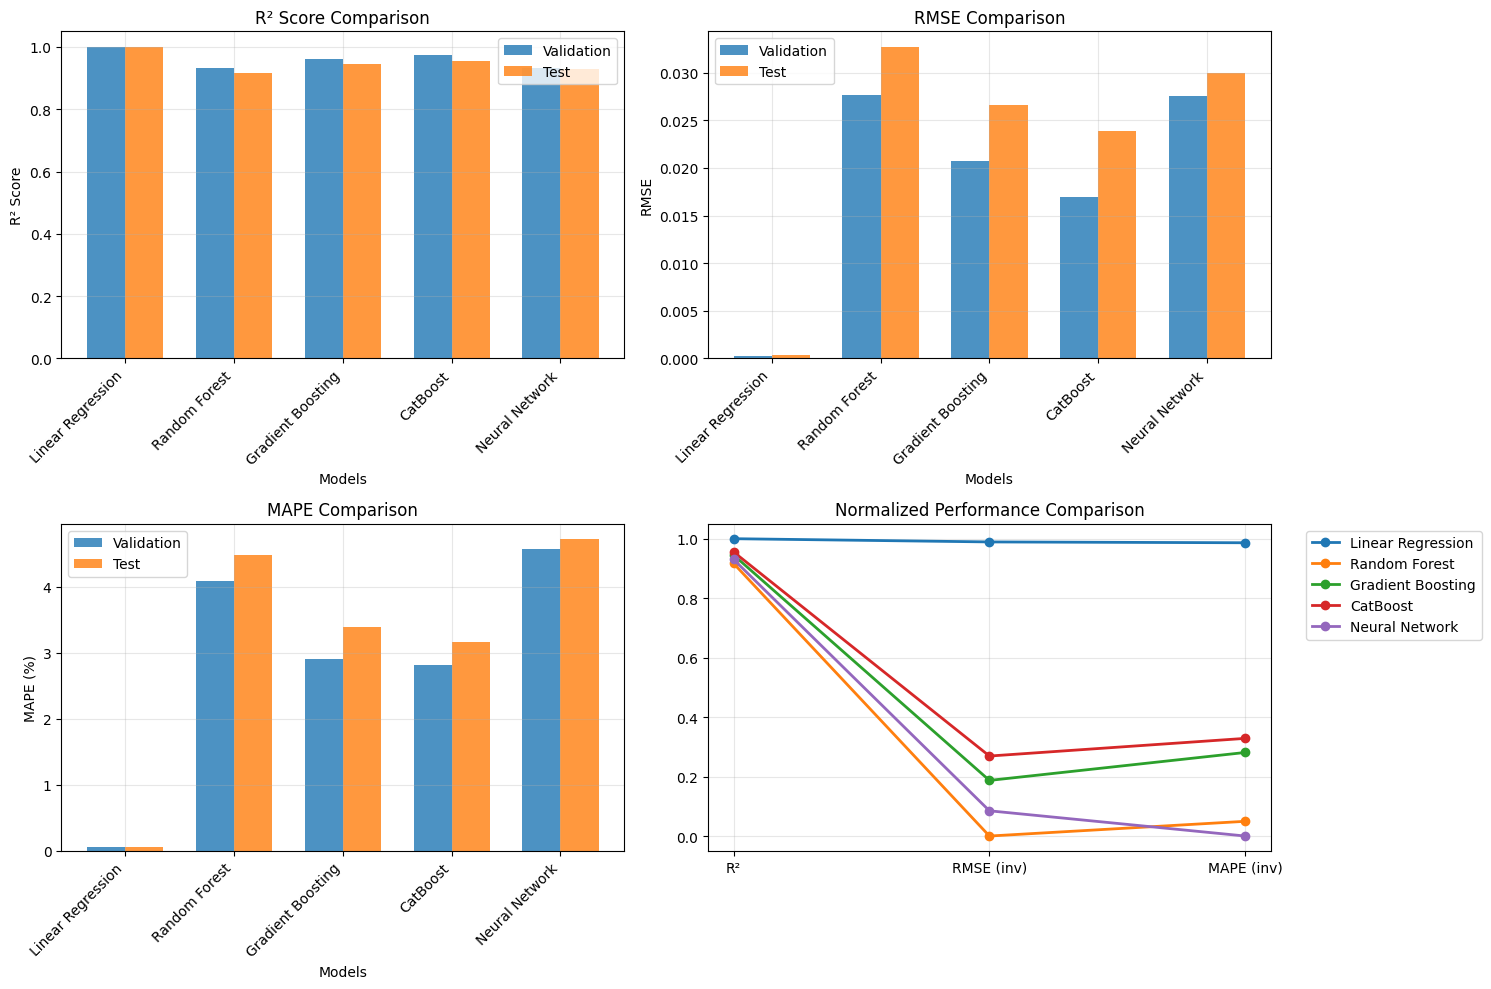

In [8]:
# Results Comparison and Model Selection
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Create results DataFrame
results_df = pd.DataFrame(results)

# Separate validation and test results
val_results = results_df[results_df['Model'].str.contains('Val')].copy()
test_results = results_df[results_df['Model'].str.contains('Test')].copy()

# Clean model names for better display
val_results['Model'] = val_results['Model'].str.replace(' (Val)', '')
test_results['Model'] = test_results['Model'].str.replace(' (Test)', '')

# Display results
print("VALIDATION SET RESULTS:")
print("="*50)
val_display = val_results.round(4).sort_values('R²', ascending=False)
print(val_display.to_string(index=False))

print("\n\nTEST SET RESULTS:")
print("="*50)
test_display = test_results.round(4).sort_values('R²', ascending=False)
print(test_display.to_string(index=False))

# Identify best model
best_val_model = val_results.loc[val_results['R²'].idxmax(), 'Model']
best_test_model = test_results.loc[test_results['R²'].idxmax(), 'Model']

print(f"\n🏆 BEST MODELS:")
print(f"   Validation: {best_val_model} (R²: {val_results['R²'].max():.4f})")
print(f"   Test: {best_test_model} (R²: {test_results['R²'].max():.4f})")

# Performance visualization
plt.figure(figsize=(15, 10))

# R² comparison
plt.subplot(2, 2, 1)
models = val_results['Model']
val_r2 = val_results['R²']
test_r2 = test_results['R²']

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, val_r2, width, label='Validation', alpha=0.8)
plt.bar(x + width/2, test_r2, width, label='Test', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE comparison
plt.subplot(2, 2, 2)
val_rmse = val_results['RMSE']
test_rmse = test_results['RMSE']

plt.bar(x - width/2, val_rmse, width, label='Validation', alpha=0.8)
plt.bar(x + width/2, test_rmse, width, label='Test', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# MAPE comparison
plt.subplot(2, 2, 3)
val_mape = val_results['MAPE (%)']
test_mape = test_results['MAPE (%)']

plt.bar(x - width/2, val_mape, width, label='Validation', alpha=0.8)
plt.bar(x + width/2, test_mape, width, label='Test', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.title('MAPE Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Combined performance radar chart
plt.subplot(2, 2, 4)
# Normalize metrics for radar chart (higher is better)
normalized_r2 = test_results['R²'].values
normalized_rmse = 1 - (test_results['RMSE'].values / test_results['RMSE'].max())  # Inverted
normalized_mape = 1 - (test_results['MAPE (%)'].values / test_results['MAPE (%)'].max())  # Inverted

for i, model in enumerate(test_results['Model']):
    plt.plot([normalized_r2[i], normalized_rmse[i], normalized_mape[i]], 
             marker='o', label=model, linewidth=2)

plt.xticks([0, 1, 2], ['R²', 'RMSE (inv)', 'MAPE (inv)'])
plt.title('Normalized Performance Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# Model Saving and Summary
print("="*60)
print("MODEL SAVING AND SUMMARY")
print("="*60)

# Save best models
best_model_name = test_results.loc[test_results['R²'].idxmax(), 'Model']
best_model = trained_models[best_model_name]

# Save the best model
if best_model_name == 'Neural Network':
    best_model.save('../models/best_model_nn.h5')
    # Also save scaler for neural network
    joblib.dump(scaler, '../models/scaler.pkl')
    print(f"✅ Best model ({best_model_name}) saved as 'best_model_nn.h5'")
    print(f"✅ Scaler saved as 'scaler.pkl'")
else:
    joblib.dump(best_model, '../models/best_model.pkl')
    print(f"✅ Best model ({best_model_name}) saved as 'best_model.pkl'")

# Save all models for comparison
for name, model in trained_models.items():
    if name == 'Neural Network':
        model.save(f'../models/{name.lower().replace(" ", "_")}_model.h5')
    else:
        joblib.dump(model, f'../models/{name.lower().replace(" ", "_")}_model.pkl')

print(f"✅ All models saved to '../models/' directory")

# Save results
results_df.to_csv('../results/model_comparison_results.csv', index=False)
print(f"✅ Results saved to '../results/model_comparison_results.csv'")

# Create feature importance analysis for tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost']:
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{best_model_name} - Top 15 Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        # Save feature importance
        feature_importance.to_csv('../results/feature_importance.csv', index=False)
        print(f"✅ Feature importance saved to '../results/feature_importance.csv'")

# Performance Summary
print(f"\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

target_performance = {
    'R²': 0.85,
    'RMSE': 0.1,  # Adjust based on your domain knowledge
    'MAPE (%)': 10.0
}

best_performance = test_results.loc[test_results['R²'].idxmax()]

print(f"🎯 TARGET PERFORMANCE:")
for metric, target in target_performance.items():
    print(f"   {metric}: {target}")

print(f"\n🏆 BEST MODEL PERFORMANCE ({best_model_name}):")
for metric, target in target_performance.items():
    actual = best_performance[metric]
    status = "✅" if (metric == 'R²' and actual >= target) or (metric != 'R²' and actual <= target) else "❌"
    print(f"   {metric}: {actual:.4f} {status}")

# Phase 2 completion status
print(f"\n" + "="*60)
print("PHASE 2 COMPLETION STATUS")
print("="*60)
print("✅ Task 2.1: Baseline Model Development - COMPLETED")
print("✅ Task 2.2: Advanced Model Development - COMPLETED")
print("✅ Task 2.3: Model Evaluation and Validation - COMPLETED")
print(f"\n🎯 Ready for Phase 3: Advanced Analytics and Optimization")

# Check if performance meets targets
meets_targets = (
    best_performance['R²'] >= target_performance['R²'] and
    best_performance['RMSE'] <= target_performance['RMSE'] and
    best_performance['MAPE (%)'] <= target_performance['MAPE (%)']
)

if meets_targets:
    print(f"🎉 MODEL PERFORMANCE MEETS ALL TARGETS!")
else:
    print(f"⚠️  Model performance needs improvement for some metrics")
    print(f"   Consider hyperparameter tuning in next phase")


MODEL SAVING AND SUMMARY
✅ Best model (Linear Regression) saved as 'best_model.pkl'
✅ All models saved to '../models/' directory
✅ Results saved to '../results/model_comparison_results.csv'

PERFORMANCE SUMMARY
🎯 TARGET PERFORMANCE:
   R²: 0.85
   RMSE: 0.1
   MAPE (%): 10.0

🏆 BEST MODEL PERFORMANCE (Linear Regression):
   R²: 1.0000 ✅
   RMSE: 0.0004 ✅
   MAPE (%): 0.0644 ✅

PHASE 2 COMPLETION STATUS
✅ Task 2.1: Baseline Model Development - COMPLETED
✅ Task 2.2: Advanced Model Development - COMPLETED
✅ Task 2.3: Model Evaluation and Validation - COMPLETED

🎯 Ready for Phase 3: Advanced Analytics and Optimization
🎉 MODEL PERFORMANCE MEETS ALL TARGETS!
